## Clustering Model 

In this project, we will be using the [Facebook Live Sellers Dataset from UCI](https://archive.ics.uci.edu/dataset/488/facebook+live+sellers+in+thailand). 

Following are the steps:
1. Loading, cleaning, and Exploring
    - Loading the Data
    - Fixing the Formats
    - Visualizing the Data
2. Dimensionality Reduction with PCA
4. Building the Model
    - K-Mean Clustering (from scratch)
    - K-Mean Clustering (sklearn)

In [43]:
## first the imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
## ML Packages
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

## setting the random seeds for reproducibility
RANDOM_SEED = 1234
np.random.seed(RANDOM_SEED)

### 1.1. Loading the Data

In [5]:
data = pd.read_csv('https://archive.ics.uci.edu/static/public/488/data.csv')
data.head()

,status_id,status_type,status_published,num_reactions,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys
0,1,video,4/22/2018 6:00,529,512,262,432,92,3,1,1,0
1,2,photo,4/21/2018 22:45,150,0,0,150,0,0,0,0,0
2,3,video,4/21/2018 6:17,227,236,57,204,21,1,1,0,0
3,4,photo,4/21/2018 2:29,111,0,0,111,0,0,0,0,0
4,5,photo,4/18/2018 3:22,213,0,0,204,9,0,0,0,0


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7050 entries, 0 to 7049
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   status_id         7050 non-null   int64 
 1   status_type       7050 non-null   object
 2   status_published  7050 non-null   object
 3   num_reactions     7050 non-null   int64 
 4   num_comments      7050 non-null   int64 
 5   num_shares        7050 non-null   int64 
 6   num_likes         7050 non-null   int64 
 7   num_loves         7050 non-null   int64 
 8   num_wows          7050 non-null   int64 
 9   num_hahas         7050 non-null   int64 
 10  num_sads          7050 non-null   int64 
 11  num_angrys        7050 non-null   int64 
dtypes: int64(10), object(2)
memory usage: 661.1+ KB


We don't have any missing values in our set, but the formats can be changed to save some memory. Also, the status_id isn't adding any value to our model, so we can simply drop that column.

### 1.2. Fixing the Formats

In [14]:
def data_cleaner(df, drop_cols = None, date_col=None):
    df.columns = [x.strip().replace(r'/s+','_').lower() for x in df.columns]
    type_dict = {}
    if drop_cols:
        df = df.drop(drop_cols,axis=1)
    for col in df.columns:
        # if df[col].dtype == 'object' and df[col].nunique() < 5:
        #     df = pd.get_dummies(data=df, columns=[col], dtype='int8')
        if df[col].dtype == 'int64' and df[col].min() == df.astype({col:'int8'})[col].min():
            type_dict[col] = 'int8'
        elif df[col].dtype == 'int64' and df[col].min() == df.astype({col:'int16'})[col].min():
            type_dict[col] = 'int16'
        elif df[col].dtype == 'int64' and df[col].min() == df.astype({col:'int32'})[col].min():
            type_dict[col] = 'int32'
        elif df[col].dtype == 'int32' and df[col].min() == df.astype({col:'int8'})[col].min():
            type_dict[col] = 'int8'
        elif df[col].dtype == 'int32' and df[col].min() == df.astype({col:'int16'})[col].min():
            type_dict[col] = 'int16'
    return df.astype(type_dict)
cleaned_data = data_cleaner(data.copy(), drop_cols=['status_id', 'status_published'])
cleaned_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7050 entries, 0 to 7049
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   status_type    7050 non-null   object
 1   num_reactions  7050 non-null   int16 
 2   num_comments   7050 non-null   int16 
 3   num_shares     7050 non-null   int16 
 4   num_likes      7050 non-null   int16 
 5   num_loves      7050 non-null   int16 
 6   num_wows       7050 non-null   int16 
 7   num_hahas      7050 non-null   int16 
 8   num_sads       7050 non-null   int8  
 9   num_angrys     7050 non-null   int8  
dtypes: int16(7), int8(2), object(1)
memory usage: 165.4+ KB


We have decreased our memory usage by 75%!

### 1.3. Visualizing the Data

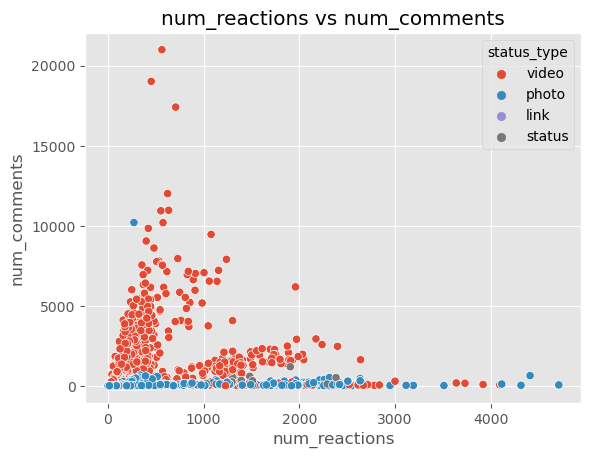

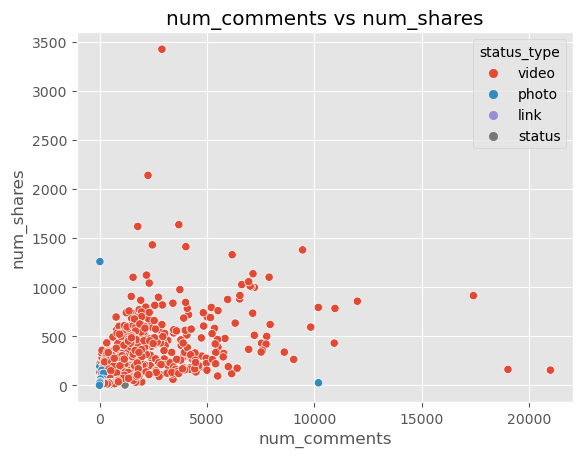

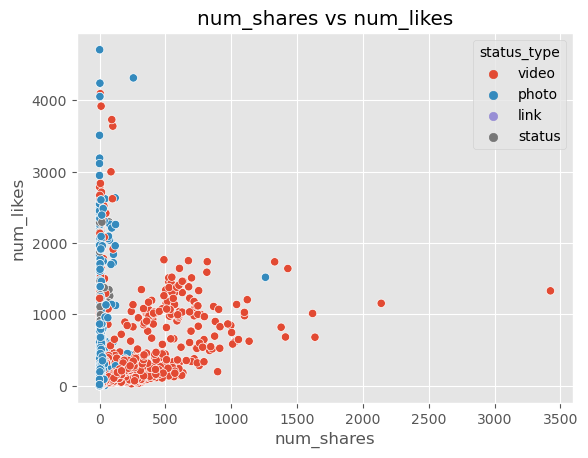

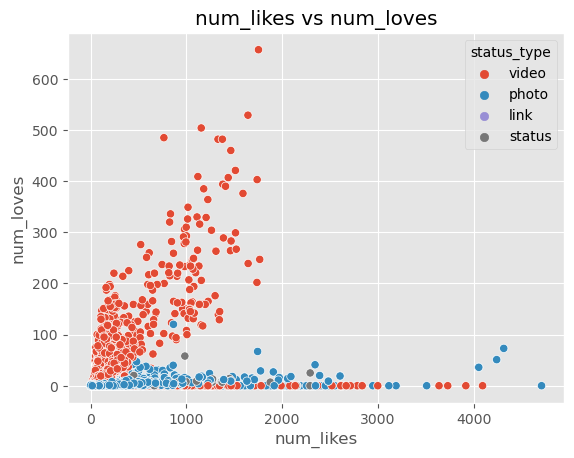

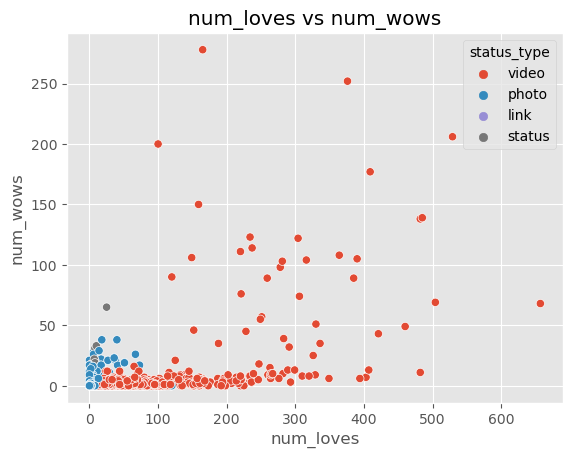

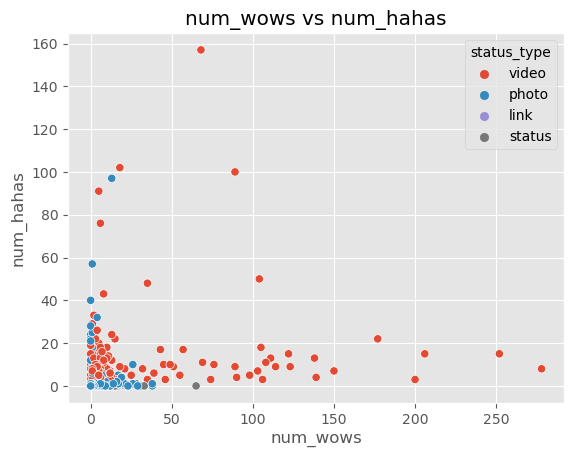

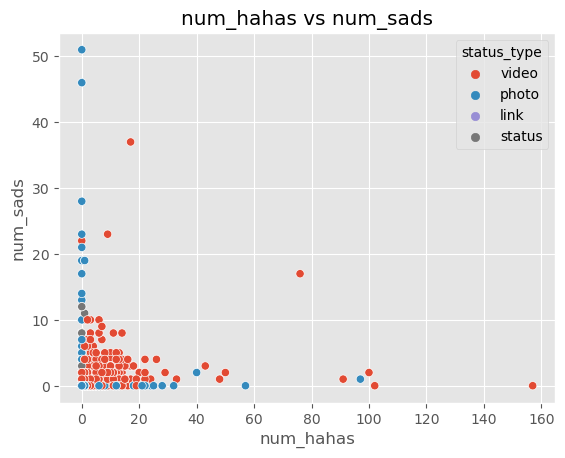

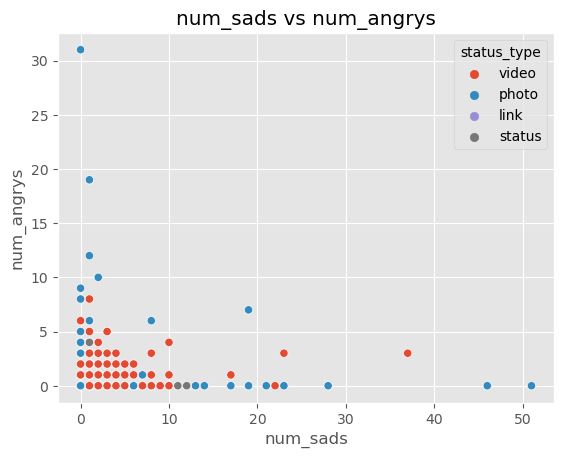

In [20]:
## we want to see how the type of status
## is impacting the reactions for each post
col_name = cleaned_data.columns.tolist()
for i in range(1, len(cleaned_data.columns[1:])):
    if i + 1 <= len(cleaned_data.columns[1:]):
        sns.scatterplot(x = col_name[i], y = col_name[i+1], data = cleaned_data, hue = 'status_type')
        plt.title(f'{col_name[i]} vs {col_name[i+1]}')
        plt.xlabel(col_name[i])
        plt.ylabel(col_name[i+1])
        plt.show();

We can see that many of the features are not adding any additional information to our dataset, and we can decrease the dimensionality of our data by **PCA**.

### 2.Dimensionality Reduction with PCA

In [45]:
## first we have to break our data into features and types
X, y = cleaned_data.drop('status_type', axis=1), cleaned_data['status_type']
## and then use PCA to reduce the number of dimensions to 3
pca = PCA(n_components=4, random_state=RANDOM_SEED)
X_transformed = pca.fit_transform(X)
## and creating labels out of classes
le = LabelEncoder()
y_transformed = le.fit_transform(y)
X.shape, X_transformed.shape, y_transformed.shape

((7050, 9), (7050, 4), (7050,))

In [46]:
## we can create the reduced set
full_reduced_set = pd.DataFrame(np.hstack([X_transformed, y_transformed.reshape(-1,1)]),
                                columns=['pca1','pca2','pca3', 'pca4', 'class'])
full_reduced_set.head()

,pca1,pca2,pca3,pca4,class
0,372.669904,308.269641,200.896194,17.237334,3.0
1,-242.585457,-59.785646,-17.952038,-2.583280,1.0
2,11.501158,-11.721604,18.359289,3.790407,3.0
3,-252.700910,-113.974859,-16.204259,-2.200953,1.0
4,-227.065240,21.618671,-16.999347,7.107766,1.0


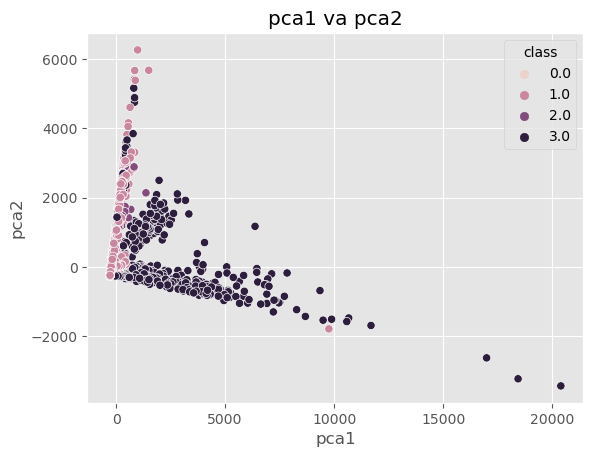

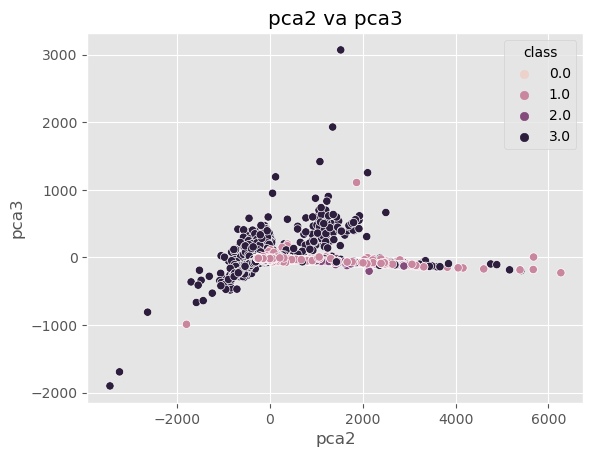

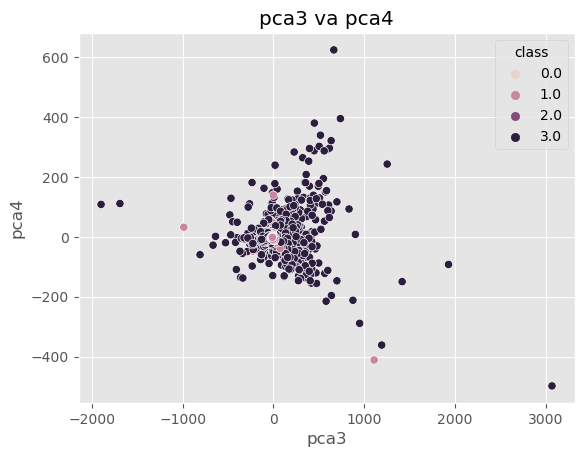

In [47]:
## and plot it again
new_col_names = full_reduced_set.columns.tolist()
for i in range(len(full_reduced_set.columns)-1):
    if i + 1 < len(full_reduced_set.columns)-1:
        sns.scatterplot(x=new_col_names[i],
                       y = new_col_names[i+1],
                       hue = 'class',
                       data = full_reduced_set)
        plt.title(f'{new_col_names[i]} va {new_col_names[i+1]}')
        plt.xlabel(new_col_names[i])
        plt.ylabel(new_col_names[i+1])
        plt.show();

### 3. Building the Model

In [51]:
km_pipe = Pipeline([('km', KMeans(random_state=RANDOM_SEED, n_clusters=4, n_init ='auto'))])
km_pipe.fit(X_transformed)
predictions = km_pipe.predict(X_transformed)

In [53]:
## putting the data together
model_reduced_set = pd.DataFrame(np.hstack([X_transformed, predictions.reshape(-1,1)]),
                                columns=['pca1','pca2','pca3', 'pca4', 'class'])
model_reduced_set.head()

,pca1,pca2,pca3,pca4,class
0,372.669904,308.269641,200.896194,17.237334,0.0
1,-242.585457,-59.785646,-17.952038,-2.583280,0.0
2,11.501158,-11.721604,18.359289,3.790407,0.0
3,-252.700910,-113.974859,-16.204259,-2.200953,0.0
4,-227.065240,21.618671,-16.999347,7.107766,0.0


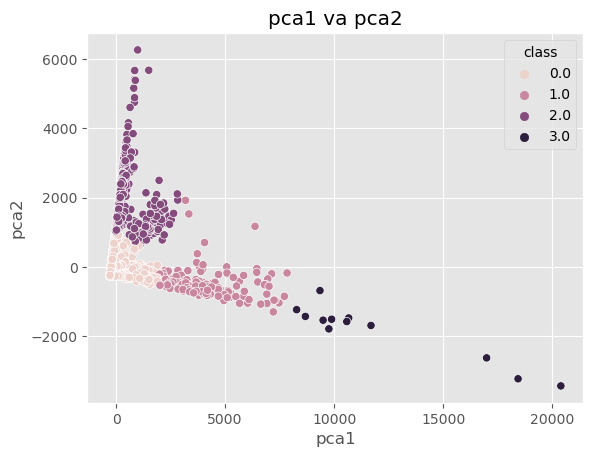

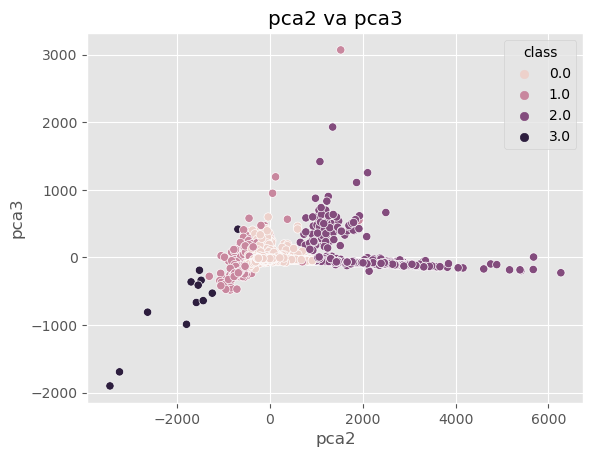

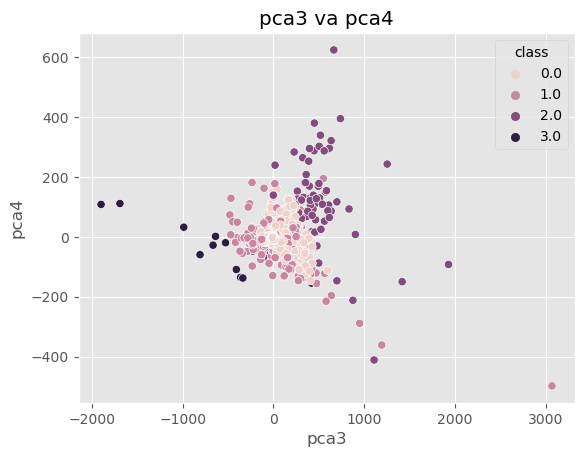

In [57]:
## and plot it again
model_col_names = model_reduced_set.columns.tolist()
for i in range(len(model_reduced_set.columns)-1):
    if i + 1 < len(model_reduced_set.columns)-1:
        sns.scatterplot(x=new_col_names[i],
                       y = new_col_names[i+1],
                       hue = 'class',
                       data = model_reduced_set)
        plt.title(f'{new_col_names[i]} va {new_col_names[i+1]}')
        plt.xlabel(new_col_names[i])
        plt.ylabel(new_col_names[i+1])
        plt.show();